<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/09_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 9: Variational Inference

This notebook is based on the previous work of Ginevra Carbone

## The problem

Given a (potentially un-normalized) density function $p(\mathbf{z})$ that is easy to evaluate on any $\mathbf{z}$ (up to a normalization constant), the objective is sample from $p(\mathbf{z})$.


This problem is often encountered when doing **bayesian inference**: Given data $D$ and model $p(D, \mathbf{z})$ where $\mathbf{z}$ are the latent variables, the posterior over the latent variables $\mathbf{z}$:

$$p(\mathbf{z} | D) \propto p(D | \mathbf{z})p(\mathbf{z})$$

is a function that is easy to evaluate for a given set of latent variables $p(\mathbf{z})$ up to a normalization constant, but it is hard to obtain samples according to it. 

### Variational Inference

A way we can solve this problem, is to find a distribution $q(\mathbf{z})$ that is "similar" to the target distribution $q(\mathbf{z})$, but from which it is easy to sample (for example a gaussian).

This approximating distribution $q(\mathbf{z})$ is oftern called the *guide*.

The space of "easy to sample from" distributions is huge, how can we choose between all possibilities?

A way to easily restrict the space of possible guides is to choose a parametric family of distributions $q_{\lambda}(\mathbf{z})$ that depends on a set of parameters $\lambda$ (for example gaussians $\mathcal{N}(\mu,\sigma)$ where $\lambda = (\mu,\sigma)$ is a family of distributions). Then looking for the best guide translates to looking for the best set of parameters $\lambda$ (optimization).

How do we measure similarity between two distributions?

We use the (direct) $D_{KL}$ divergence: 

$$D_{KL}[q_{\lambda} || p]$$

that is $0$ when $q_{\lambda} = p$.


<img src="https://i.imgur.com/8kBcvsj.png" width="800">


### Evidence Lower Bound (ELBO)

There are good reasons to choose $D_{KL}[q_{\lambda} || p]$ as a measure of dissimilarity, let's develop the expression:

$$D_{KL}[q_{\lambda} || p] = \mathbb{E}_{\mathbf{z} \sim q_{\lambda}(\mathbf{z})} \left[ \log{q_{\lambda}(\mathbf{z})} - \log{\frac{\tilde{p}(\mathbf{z})}{Z}} \right] = \mathbb{E}_{\mathbf{z} \sim q_{\lambda}(\mathbf{z})} \left[ \log{q_{\lambda}(\mathbf{z})} - \log{\tilde{p}(\mathbf{z})} \right] + \log{Z}$$

Considering that $\log{Z}$ does not depend on the guide $\log{q_{\lambda}(\mathbf{z})}$, minimizing this expression is equivalente to maximizing the following one:

$$\mathbb{E}_{\mathbf{z} \sim q_{\lambda}(\mathbf{z})} \left[\log{\tilde{p}(\mathbf{z})} - \log{q_{\lambda}(\mathbf{z})} \right] = \mathbb{E}_{\mathbf{z} \sim q_{\lambda}(\mathbf{z})} \left[\log{\tilde{p}(\mathbf{z})} \right] + H[q_\lambda]$$

You can interpret this in the following way: a good guide samples points $\mathbf{z}$ that are highly probable according to $\tilde{p}(\mathbf{z})$ (first term) but at the same time it should be dispersed enough (entropy term), otherwise it will only sample the most probable point according to $\tilde{p}(\mathbf{z})$.

In the bayesian setting, we have $p(\mathbf{z}) = p(\mathbf{z} | D)$ (the posterior) so $\tilde{p}(\mathbf{z}) = p(D , \mathbf{z}) = p(D | \mathbf{z}) p(\mathbf{z})$ (the unnormalized posterior). So the expression gets:

$$\text{ELBO}(q_{\lambda}) := \mathbb{E}_{\mathbf{z} \sim q_{\lambda}(\mathbf{z})} \left[\log{p(D , \mathbf{z})} - \log{q_{\lambda}(\mathbf{z})} \right]$$

This is known as the Evidence Lower Bound, as it is easy to show that it is a lower bound for the evidence $\log{p(D)}$.

So in variational inference we reduce the inference problem to an optimization problem:
$$ \argmax_{q_\lambda} \text{ELBO}(q_\lambda) $$

Considering that we are using a parametric family of distributions $q_\lambda$, then this reduces to the optimization of a set of parameters:
$$\argmax_{\lambda} \text{ELBO}(\lambda)$$

### Black Box Variational Inference

In order to find $\argmax_{\lambda} \text{ELBO}(\lambda)$, we would like to perform a gradient-based optimization, but $\nabla_\lambda\text{ELBO}(\lambda)$ contains an intractable expectation.
We would like to estimate the gradient of this expectation by Monte Carlo.
Depending on $q_\lambda$, there are two ways to do this:

#### Reparametrization Trick

The reparametrization trick consist in writing samples $\mathbf{z}$ from $q_\lambda$ as $\mathbf{z} = f_{\lambda}(\boldsymbol{\varepsilon})$ where $\boldsymbol{\varepsilon}$ is a random variable sampled from a distribution $\hat{q}$ that does not depend on $\lambda$.

For example this can be done with the normal distribution: sampling $z \sim \mathcal{N}(\mu, \sigma)$ is equivalent to $z = \mu + \sigma \cdot \varepsilon$ with $\varepsilon \sim \mathcal{N}(0, 1)$.

If we can do the reparametrization trick then we have:

$$\nabla_\lambda\text{ELBO}(\lambda)  = \nabla_\lambda\mathbb{E}_{\mathbf{z} \sim q_{\lambda}(\mathbf{z})} \left[\log{\tilde{p}(\mathbf{z})} - \log{q_{\lambda}(\mathbf{z})} \right] = \nabla_\lambda\mathbb{E}_{\boldsymbol{\varepsilon} \sim \tilde{q}(\boldsymbol{\varepsilon})} \left[\log{\tilde{p}(f_{\lambda}(\boldsymbol{\varepsilon}))} - \log{q_{\lambda}(f_{\lambda}(\boldsymbol{\varepsilon}))} \right]$$

Since the distribution relative to the expectation does not depend on $\lambda$ anymore, we can bring the gradient operator inside the expectation:

$$\nabla_\lambda\text{ELBO}(\lambda)  = \mathbb{E}_{\boldsymbol{\varepsilon} \sim \tilde{q}(\boldsymbol{\varepsilon})} \nabla_\lambda \left[ \log{\tilde{p}(f_{\lambda}(\boldsymbol{\varepsilon}))} - \log{q_{\lambda}(f_{\lambda}(\boldsymbol{\varepsilon}))} \right]$$

We can estimate this gradient by Monte Carlo, and the use it to optimize the ELBO:

$$\nabla_\lambda\text{ELBO}(\lambda)  \approx \frac{1}{S} \sum_{s=1}^S  \nabla_\lambda \left[ \log{\tilde{p}(f_{\lambda}(\boldsymbol{\varepsilon}_s))} - \log{q_{\lambda}(f_{\lambda}(\boldsymbol{\varepsilon}_s))} \right] $$

with $\boldsymbol{\varepsilon}_s \sim \tilde{q}(\boldsymbol{\varepsilon})$

**Example:**
Find a variational approximation of $p(z) \propto e^{-3|x-2|}$ using a gaussian guide $q_{\mu, \sigma}(z) = \mathcal{N}(z;\mu,\sigma)$

In [ ]:
import torch
from torch import distributions
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

def gradient_descent_optimization(*, loss_function, lr: float, n_iter: int, initial_guess: np.ndarray) -> np.ndarray:
    w = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    for _ in tqdm(range(n_iter)):
        loss = loss_function(w)
        loss.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad = None
    print(f"loss={ loss.item():.4g}")
    return w.cpu().detach().numpy()

def log_p(z) -> torch.Tensor:
    # TODO
    return ...

def log_q(z, mu, sigma) -> torch.Tensor:
    # TODO
    return ...

def loss(param):
    # TODO
    return ...
    

params = gradient_descent_optimization(loss_function=loss,
                                        lr=0.01,
                                        n_iter=1000,
                                        initial_guess=[0.0, 10.0])

mu = params[0]
sigma = params[1]

print(f"mean = {mu:.3f}, std = {sigma:.3f}")

# plotting the result
z_values = torch.linspace(-3, 5, 400)
log_p_values = log_p(z_values).exp()
log_q_values = log_q(z_values, mu, sigma).exp()
plt.figure(dpi=100)
plt.plot(z_values.numpy(), log_p_values.numpy(), label='p (unnormalized)')
plt.plot(z_values.numpy(), log_q_values.numpy(), label='q')
_ = plt.legend()


#### Non-reparametrizable guide

In many cases the guide is not reparametrizable, but also in this case it is still possible to approximate the gradient, at the price of a higher variance of the estimation (see lectures' notes for a proof):

$$\nabla_\lambda\text{ELBO}(\lambda)  \approx \frac{1}{S} \sum_{s=1}^S  \nabla_\lambda \left[ \log q_{\lambda}(\boldsymbol{z}_s) \right] \left( \log{\tilde{p}(\boldsymbol{z}_s)} - \log{q_{\lambda}(\boldsymbol{z}_s)} \right)$$

This is how pyro computes the gradient for any guide. 

## Variational Inference with Pyro

Stochastic variational inference is implemented as a pyro class

```
SVI(model, guide, optim, loss)
```

whose arguments are a **model** function, a **guide** function, a pytorch optimizer and
the ELBO loss function.

`model()` is a stochastic function that implements the generative process and is conditioned on the observations.

`guide()` represents the variational distribution $q_{\lambda}(z)$, so it needs to provide a valid joint probability density over all the latent random variables in the model.

Keep in mind that these two methods:
- should always take the same arguments
- should both sample the parameters that have to be inferred and use the same names for them, but not necessarily the same distributions

For example

```
def model(data):
    pyro.sample("theta", Uniform(-1.,1.))
    ...
   
def guide(data):
    pyro.sample("theta", Normal(0.,1.))
    ... 
```

The **optimization step** is performed by calling `step()` on the training batch data:

```
optim = Adam({lr:0.02}) 
loss = ELBO_loss()
svi = SVI(model, guide, optim, loss)

for step in range(n_steps):
    for batch_data in training_data:
        svi.step(batch_data)
```

The name "stochastic" is due to the batch training technique.

### Example: Linear Regression with SVI

First, we load the data and normalize it:

,x,y
0,0.851025,6.302669
1,0.501799,12.503790
2,0.190843,22.513496
3,0.010765,21.757860
4,0.714032,-0.905797
5,2.342547,-4.793330
6,1.524679,-2.594179
7,0.030191,13.123643
8,-1.846746,18.243612
9,0.003495,29.093051


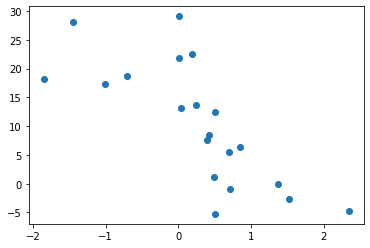

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/vi_regression.csv')

In [ ]:
# Let's normalize the data, in order to improve the convergence of optimizers
df = (df - df.mean()) / df.std()

The data has just one feature and one value to predict. The following is a linear model describing the observed data:

\begin{align*}



& p(y_i | x_i, w, b, \sigma) = \mathcal{N}(y_i; x_i \cdot w + b, \sigma) \\

& w \sim \mathcal{N}(0,100) \\
& b \sim \mathcal{N}(0,100) \\
& \sigma \sim \text{Uniform}(0,100) \\

\end{align*}



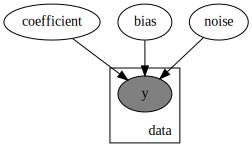

In [ ]:
import pyro
import torch
from pyro.distributions import Normal, Uniform, LogNormal
from pyro.distributions import constraints

W_PRIOR_SIGMA = 100.0
BIAS_PRIOR_SIGMA = 100.0
SIGMA_MAX = 100.0

def model(x: torch.Tensor, y: torch.Tensor | None = None) -> torch.Tensor:
    # priors
    coefficient = pyro.sample('coefficient', Normal(0, W_PRIOR_SIGMA))
    bias = pyro.sample('bias', Normal(0, BIAS_PRIOR_SIGMA))
    sigma = pyro.sample('noise', Uniform(0, SIGMA_MAX))
    
    # likelihood/observation
    with pyro.plate('data', len(x)):
        y = pyro.sample('y', Normal(coefficient * x + bias, sigma), obs=y)
    return y

pyro.render_model(model, model_args=(torch.zeros(1),torch.zeros(1)))

If we want to do VI, we have to build a guide.

A guide is made in the same way we build models. Being a distribution over the latent variables, you have to sample those inside its definition, using the same names as in the model, and you can define parameters that parametrize the distribution.

Moreover, the arguments of the guide function has to be the same of the model.

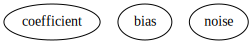

In [ ]:
def guide(x: torch.Tensor, y: torch.Tensor | None = None):
    
    # guide optimizable parameters
    coefficient_mu = pyro.param('coefficient_mu', torch.tensor(0.0))
    coefficient_sigma = pyro.param('coefficient_sigma', torch.tensor(10.0), constraint=constraints.positive)
    
    bias_mu = pyro.param('bias_mu', torch.tensor(0.0))
    bias_sigma = pyro.param('bias_sigma', torch.tensor(10.0), constraint=constraints.positive)
    
    sigma_mu = pyro.param('sigma_mu', torch.tensor(0.0))
    sigma_sigma = pyro.param('sigma_sigma', torch.tensor(1.0), constraint=constraints.positive)

    # guide distributions
    coefficient = pyro.sample('coefficient', Normal(coefficient_mu, coefficient_sigma))
    bias = pyro.sample('bias', Normal(bias_mu, bias_sigma))
    sigma = pyro.sample('noise', LogNormal(sigma_mu, sigma_sigma))
    
    return coefficient, bias, sigma

# This doesn't make much sense, but it's just to show the guide
pyro.render_model(guide, model_args=(torch.zeros(1),torch.zeros(1)))

Notice that we defined a guide where each latent variable is an independent distribution, so it's a mean-field approximation.

Now we can perform SVI and optimize the guide's parameters:

  0%|          | 0/100 [00:00<?, ?it/s]

Elbo loss: 48.088819071650505


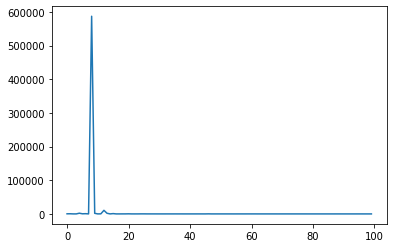

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from tqdm.notebook import tqdm

pyro.clear_param_store()

# convert the data to torch tensors
data = torch.tensor(df.to_numpy(), dtype=torch.float32)
x = data[:,0] 
y = data[:,1]

NUM_PARTICLES = 1 # number of samples to estimate the gradient od the ELBO
STEPS = 100 # optimization steps

# defining the SVI object
svi = SVI(model=model,
          guide=guide,
          optim=ClippedAdam({'lr': 0.05}),
          loss=Trace_ELBO(num_particles=NUM_PARTICLES))

# fitting the guide to the data
loss = np.zeros(STEPS)
for i in tqdm(range(STEPS)):        
    loss[i] = svi.step(x, y)
    
print(f"Elbo loss: {loss[-1]}")
_ = plt.plot(loss)

Where are the optimized parameters of the guide? They are saved under the hood in an object named `pyro.get_param_store()`:

In [ ]:
dict(pyro.get_param_store())

{'coefficient_mu': tensor(-0.7166, requires_grad=True),
 'coefficient_sigma': tensor(0.5419, grad_fn=<AddBackward0>),
 'bias_mu': tensor(0.2455, requires_grad=True),
 'bias_sigma': tensor(0.6130, grad_fn=<AddBackward0>),
 'sigma_mu': tensor(0.1017, requires_grad=True),
 'sigma_sigma': tensor(0.3092, grad_fn=<AddBackward0>)}

Now we can use the fitted guide to sample from the predictive distribution, `pyro` has a function to do that:

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model=model, guide=guide, num_samples=1_000)

# Let's use as input some equidistant points in the range of the data
x_linspace = torch.linspace(-4, 4, 20)

mf_pred = predictive(x_linspace)
mf_pred.keys()

dict_keys(['coefficient', 'bias', 'noise', 'y'])

So we can obtain both samples from the posterior (of the latent variables) and samples from the predictive

In [ ]:
mf_pred

{'coefficient': tensor([[-5.5698e-01],
         [ 1.7674e-01],
         [-9.0354e-03],
         [-5.8622e-01],
         [ 2.0230e-01],
         [-6.3248e-01],
         [-2.6217e-01],
         [-2.3309e+00],
         [-3.6950e-01],
         [-7.0625e-01],
         [-9.3522e-01],
         [-7.6762e-01],
         [-5.0454e-01],
         [ 3.1659e-01],
         [-6.6352e-01],
         [ 9.3574e-02],
         [ 5.4043e-02],
         [-1.1092e+00],
         [-3.6828e-01],
         [-8.9140e-01],
         [-5.1815e-01],
         [-1.1695e+00],
         [ 3.3721e-01],
         [-1.4584e+00],
         [-3.9514e-01],
         [-1.6792e+00],
         [ 1.0985e-01],
         [-5.2928e-01],
         [-1.0101e+00],
         [-7.2041e-01],
         [-6.8963e-01],
         [-4.8350e-01],
         [-4.8075e-01],
         [-8.1639e-01],
         [-8.2440e-01],
         [-1.1729e+00],
         [ 2.4420e-01],
         [ 2.9895e-01],
         [-6.6914e-02],
         [ 1.1605e+00],
         [ 1.7107e-01],
 

Let's use the simulations to plot theregression line and the confidence interval:

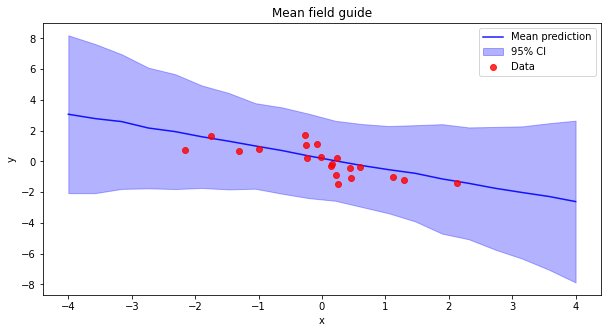

In [ ]:
y_pred = mf_pred['y'].detach().numpy()

y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(0)

# Compute confidence interval bounds
ci_upper = y_mean + 1.96 * y_std
ci_lower = y_mean - 1.96 * y_std

# Plot mean and confidence interval
plt.figure(figsize=(10, 5))
plt.plot(x_linspace, y_mean, color='blue', label='Mean prediction', alpha = 0.9)
plt.fill_between(x_linspace, ci_lower, ci_upper, color='blue', alpha=0.3, label='95% CI')
plt.scatter(df['x'], df['y'], color='red', label='Data', alpha = 0.8, zorder=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mean field guide')
plt.show()

#### Auto Guides

There is also the possibility to avoid specifying the guide manually, and just use a "standard" guide, for example a diagonal normal or a multivariate normal. Pyro is able to recognize the latent variables of a model and build one of these standard guides.

In this case let's increase the complexity of the guide using a multivariate normal (so allowing correlations among latent variables): 

  0%|          | 0/400 [00:00<?, ?it/s]

Elbo loss: 38.74979376792908


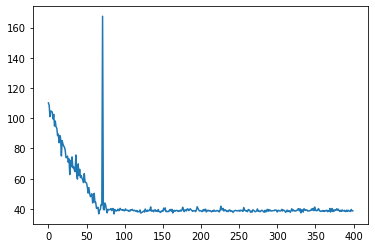

In [ ]:
from pyro.infer.autoguide import AutoMultivariateNormal

pyro.clear_param_store()

# Building the guide automatically 
auto_guide = AutoMultivariateNormal(model)

NUM_PARTICLES = 2
STEPS = 400
AutoMultivariateNormal
svi = SVI(model=model,
          guide=auto_guide,
          optim=ClippedAdam({'lr': 0.1}),
          loss=Trace_ELBO(num_particles=NUM_PARTICLES))

loss = np.zeros(STEPS)
for i in tqdm(range(STEPS)):        
    loss[i] = svi.step(x, y)
print(f"Elbo loss: {loss[-1]}")
_ = plt.plot(loss)

In [ ]:
dict(pyro.get_param_store())

{'AutoMultivariateNormal.loc': Parameter containing:
 tensor([-0.7856,  0.0084, -4.9685], requires_grad=True),
 'AutoMultivariateNormal.scale': tensor([0.1466, 0.1390, 0.1143], grad_fn=<SoftplusBackward0>),
 'AutoMultivariateNormal.scale_tril': tensor([[ 1.0000,  0.0000,  0.0000],
         [ 0.0552,  1.0000,  0.0000],
         [-0.1374, -0.1837,  1.0000]], grad_fn=<AddBackward0>)}

You can see that now you have also a covariance over the latent variables.

Unfortunately there are no names, so you have to follow the order you defined the latent variables.

Again, let's make a plot of the predictions:

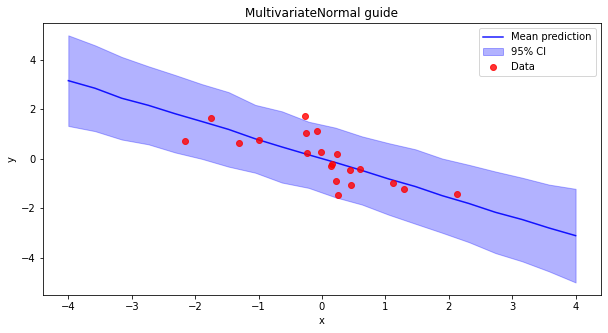

In [ ]:
predictive = Predictive(model=model, guide=auto_guide, num_samples=1_000)

x_linspace = torch.linspace(-4, 4, 20)
pred = predictive(x_linspace)
y_pred = pred['y'].detach().numpy()

y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(0)

# Compute confidence interval bounds
ci_upper = y_mean + 1.96 * y_std
ci_lower = y_mean - 1.96 * y_std

# Plot mean and confidence interval
plt.figure(figsize=(10, 5))
plt.plot(x_linspace, y_mean, color='blue', label='Mean prediction', alpha = 0.9)
plt.fill_between(x_linspace, ci_lower, ci_upper, color='blue', alpha=0.3, label='95% CI')
plt.scatter(df['x'], df['y'], color='red', label='Data', alpha = 0.8, zorder=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('MultivariateNormal guide')
plt.show()